In [2]:
import sys
import pandas as pd
import numpy as np

# add root folder to path
folder = "../../"
sys.path.append(folder)
from src.utils import load_data
from src.utils import plot_metrics_grid
from src.utils import load_baseline_rec_result
from src.metrics import evaluate_recommender_system

In [3]:
users, ratings, movies = load_data('../../data/ml-1m/')

# Split data into train and test by timestamp
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
split_point = int(len(ratings) * 0.8)
sorted_ratings = ratings.sort_values(by='timestamp')
train_ratings = sorted_ratings[:split_point].copy()
test_ratings = sorted_ratings[split_point:].copy()

train_ratings.drop('timestamp', axis=1, inplace=True)
test_ratings.drop('timestamp', axis=1, inplace=True)

In [4]:
R_df = train_ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
R = R_df.values

def als(R, num_factors=10, num_iterations=10, regularization=0.1):
    num_users, num_items = R.shape
    U = np.random.normal(scale=1./num_factors, size=(num_users, num_factors))
    V = np.random.normal(scale=1./num_factors, size=(num_items, num_factors))

    for iteration in range(num_iterations):
        for u in range(num_users):
            V_u = V[R[u, :] > 0]
            R_u = R[u, R[u, :] > 0]
            U[u] = np.linalg.solve(np.dot(V_u.T, V_u) + regularization * np.eye(num_factors), np.dot(V_u.T, R_u))

        for i in range(num_items):
            U_i = U[R[:, i] > 0]
            R_i = R[R[:, i] > 0, i]
            V[i] = np.linalg.solve(np.dot(U_i.T, U_i) + regularization * np.eye(num_factors), np.dot(U_i.T, R_i))

        loss = 0
        for u in range(num_users):
            for i in range(num_items):
                if R[u, i] > 0:
                    loss += (R[u, i] - np.dot(U[u], V[i])) ** 2
        loss += regularization * (np.linalg.norm(U) + np.linalg.norm(V))
        print(f"Iteration {iteration+1}/{num_iterations}, Loss: {loss}")

    return U, V

num_factors = 5
num_iterations = 20
regularization = 0.1

U, V = als(R, num_factors=num_factors, num_iterations=num_iterations, regularization=regularization)

R_hat = np.dot(U, V.T)
R_hat_df = pd.DataFrame(R_hat, index=R_df.index, columns=R_df.columns)

Iteration 1/20, Loss: 5805189.631783833
Iteration 2/20, Loss: 628415.5818231236
Iteration 3/20, Loss: 548660.3869207795
Iteration 4/20, Loss: 535740.3976143469
Iteration 5/20, Loss: 530597.9760690192
Iteration 6/20, Loss: 527818.8302977404
Iteration 7/20, Loss: 526015.2196640989
Iteration 8/20, Loss: 524734.5402795784
Iteration 9/20, Loss: 523795.3670129702
Iteration 10/20, Loss: 523107.18333147996
Iteration 11/20, Loss: 522605.4106761865
Iteration 12/20, Loss: 522250.9417041657
Iteration 13/20, Loss: 521996.7080914314
Iteration 14/20, Loss: 521811.13282240526
Iteration 15/20, Loss: 521675.59454278665
Iteration 16/20, Loss: 521576.8282182683
Iteration 17/20, Loss: 521504.5903320014
Iteration 18/20, Loss: 521450.82285992545
Iteration 19/20, Loss: 521409.36271136976
Iteration 20/20, Loss: 521377.431333007


In [5]:
def get_user_recommendations_test(user_id, R_hat, top_n=5):
    if user_id not in R_df.index:
        print(f"User ID {user_id} not found in the training dataset.")
        return []

    user_index = R_df.index.get_loc(user_id)
    user_predicted_ratings = R_hat[user_index]

    recommended_items_indices = np.argsort(user_predicted_ratings)[::-1][:top_n]
    recommended_items = R_df.columns[recommended_items_indices]

    return recommended_items

User ID 634 not found in the training dataset.
User ID 633 not found in the training dataset.
User ID 632 not found in the training dataset.
User ID 631 not found in the training dataset.
User ID 630 not found in the training dataset.
User ID 628 not found in the training dataset.
User ID 629 not found in the training dataset.
User ID 627 not found in the training dataset.
User ID 626 not found in the training dataset.
User ID 625 not found in the training dataset.
User ID 624 not found in the training dataset.
User ID 623 not found in the training dataset.
User ID 622 not found in the training dataset.
User ID 621 not found in the training dataset.
User ID 620 not found in the training dataset.
User ID 619 not found in the training dataset.
User ID 618 not found in the training dataset.
User ID 617 not found in the training dataset.
User ID 616 not found in the training dataset.
User ID 615 not found in the training dataset.
User ID 614 not found in the training dataset.
User ID 613 n

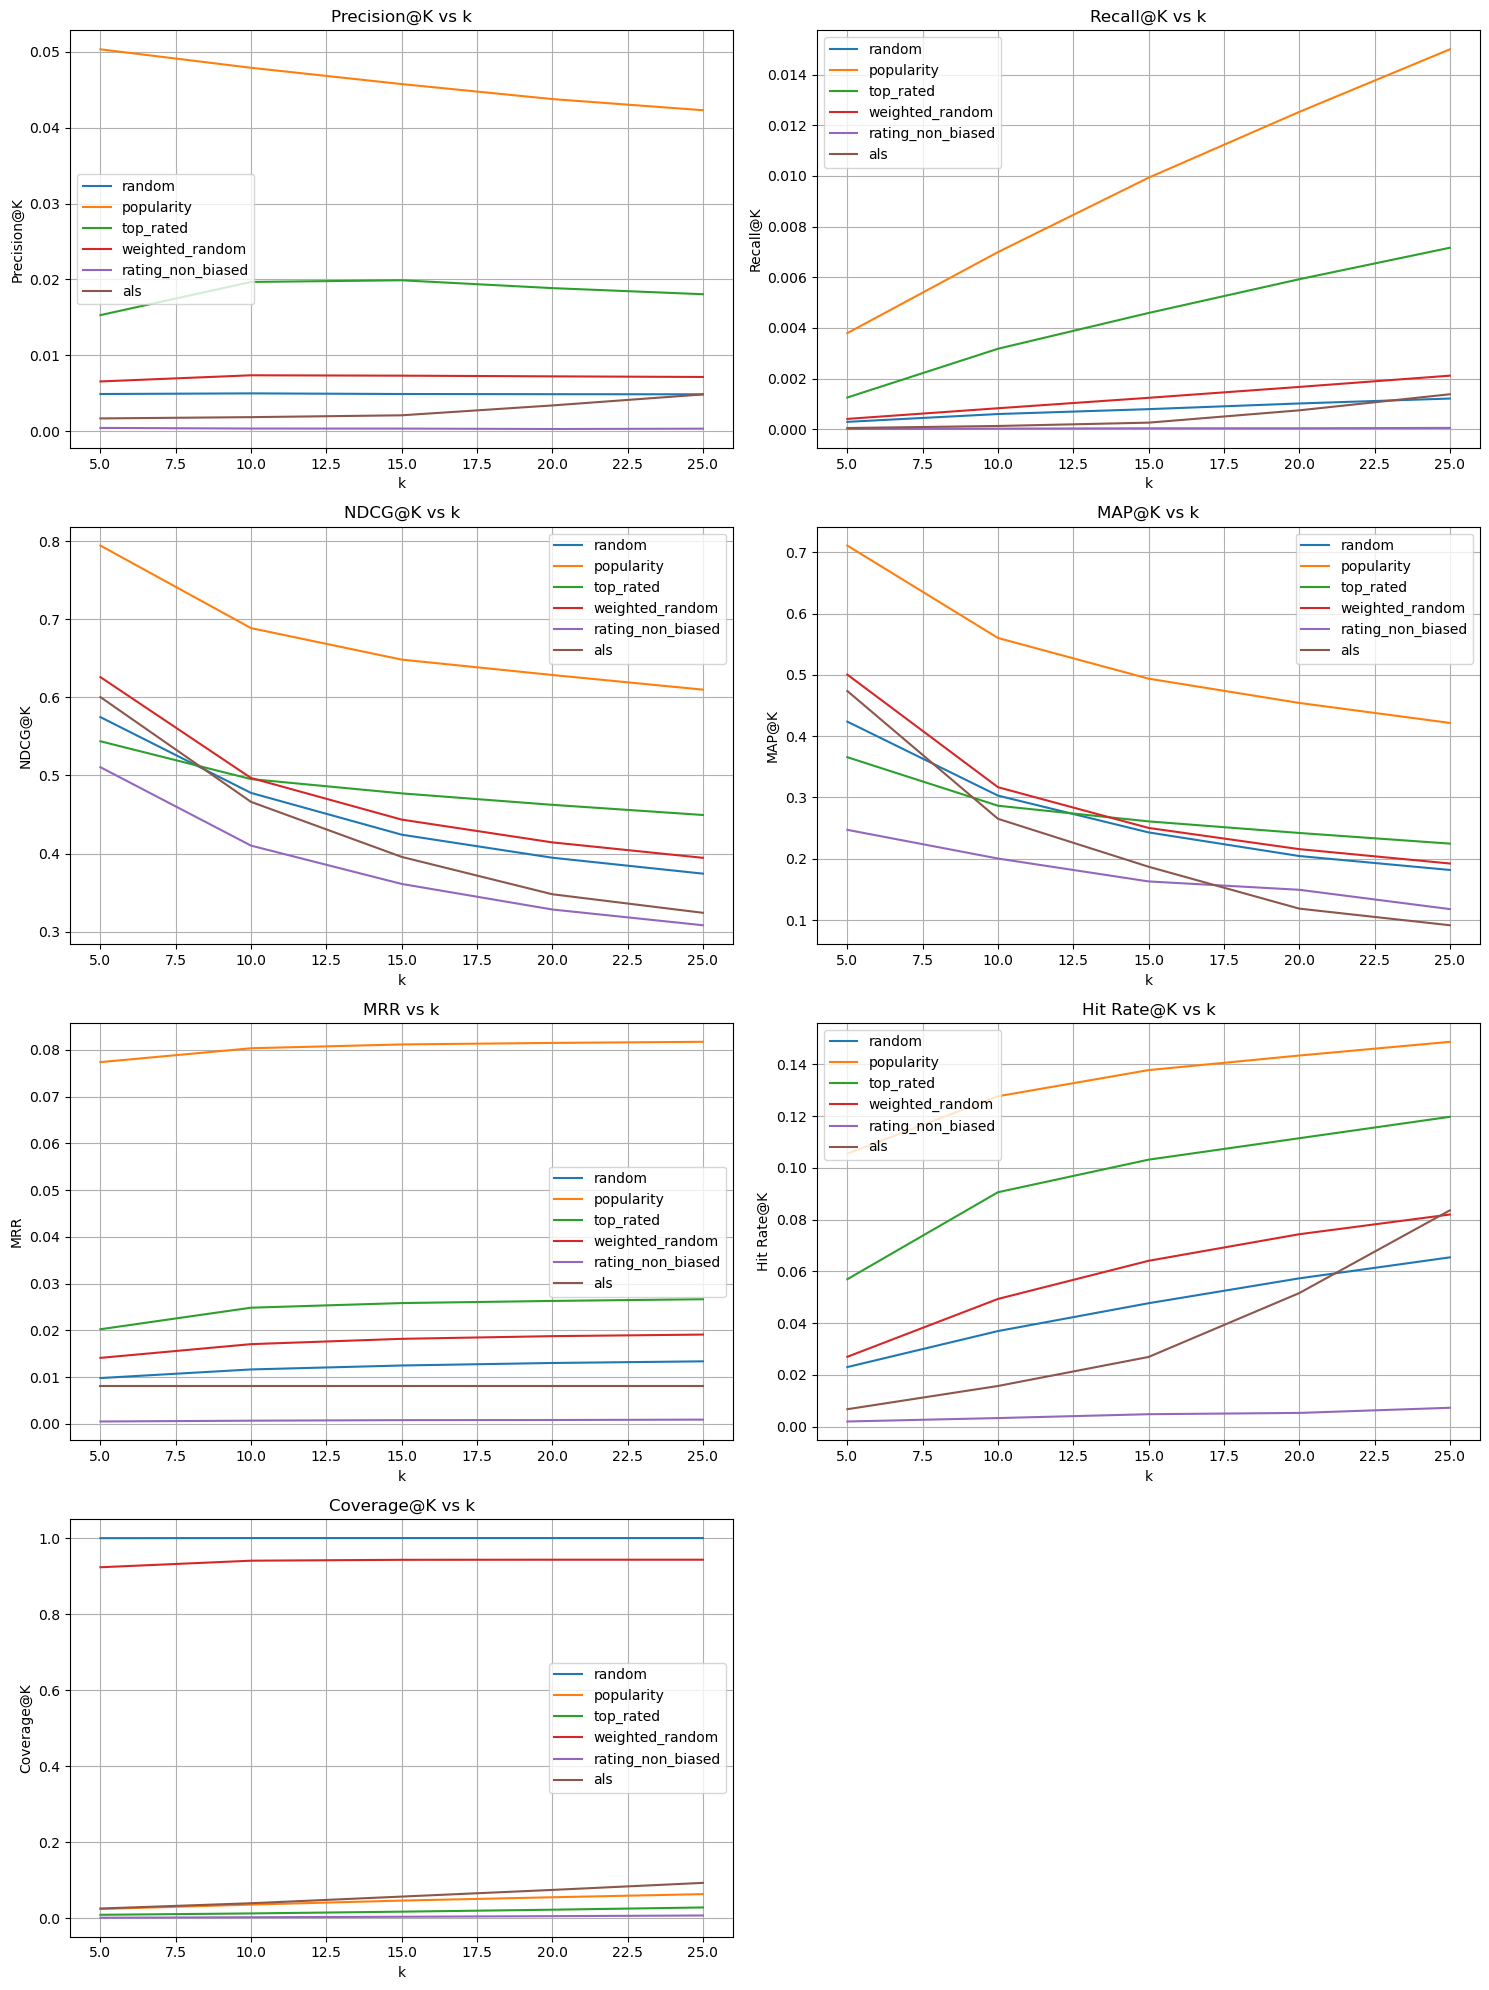

In [6]:
metrics_results = {}
base_line_metrics = load_baseline_rec_result()
recommendations = {}
for user_id in test_ratings['user_id'].unique():
    recommendations[user_id] = get_user_recommendations_test(user_id,R_hat, 25)
for i in range(5, 26, 5):
    metrics_results[i] = evaluate_recommender_system(dict(list(recommendations.items())), test_ratings, len(movies),i)

combined = base_line_metrics | {'als': metrics_results}
metrics = ['Precision@K', 'Recall@K', 'NDCG@K', 'MAP@K', 'MRR', 'Hit Rate@K', 'Coverage@K']
plot_metrics_grid(combined, metrics)